In [4]:
%run StoreTweetsBackend.ipynb

Growth SET
GPU ACTIVE
{'limit': 15, 'remaining': 15, 'reset': 1616091129}
{'limit': 900, 'remaining': 900, 'reset': 1616091129}
sentimentDB exists.
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'sentimentDB')


# Sentiment

## Load Tweet Data

https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020

In [37]:
# datasets=["Company.csv","Company_Tweet.csv","Tweet.csv"]
# tweetdata= (pd.read_csv("D:/Downloads/archive (1)/{0}".format(datasets[2]),parse_dates=[0])).sort_values('post_date')
# tweetdata=tweetdata.set_index(pd.to_datetime(tweetdata["post_date"], unit='s',utc=True).dt.date)
# tweetdata=tweetdata.drop(columns=["writer","tweet_id",'post_date',"comment_num","retweet_num","like_num"])
# tweetdata=load("tweetdata")

Sentiment140

In [61]:
sentiment140Value=(getQueryFromMongoDB("processedSentiment140").sort_values('SentimentScore'))[["_id",'SentimentScore','processed']]
sentiment140Value=sentiment140Value.sample(frac=1)
sentiment140Value=sentiment140Value.drop_duplicates(subset=['processed'])
trainX, testX, trainY, testY =train_test_split(sentiment140Value['processed'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

## Creating a Tweet Preprocessor

In [43]:
punctuations=set(string.punctuation)
stopwordset=set(stopwords.words('english'))
stopwordsetNP=[re.sub(r"[^\ 0-9a-zA-Z]+",r"",w) for w in stopwordset]
trans=str.maketrans('','',string.punctuation)

In [23]:
from nltk.corpus import stopwords
class processer():
    def __init__(self,stemmer=None,tokenize=False,stopword=True, lower=True,links=True,retweets=True, users=True, hashtags=True, specialChars=True, nums=True, shortenBegin=True,repeats=True):
        self.stopwordset=[]
        if stopword: self.stopwordset=[word.translate(trans) for word in stopwords.words('english')]#Optimization
        self.regex=r"^"
        self.lower=lower
        self.stemmer=stemmer
        self.stopword=stopword
        self.tokenize=tokenize
        if links:        self.regex=self.regex+r"|(((((https?)?:\/\/)(www\.)?|www\.))([a-z0-9.]+)(\.[a-z]{2,4})(\.[a-z]{1,2})?([^?\s]+(\?((\w+)(=[^&\s]+)?&?)+)?)?)"
        if retweets:     self.regex=self.regex+r"|(RT \@[a-zA-Z0-9_.]*: )"
        if users:        self.regex=self.regex+r"|(\@[a-zA-Z0-9_.]* )"
        if hashtags:     self.regex=self.regex+r"|(\#[a-zA-Z0-9_%]*)"
        if specialChars: self.regex=self.regex+r"|([^\ 0-9a-zA-Z]+)"
        if nums:         self.regex=self.regex+r"|([0-9]*)"
        self.shortenBegin=shortenBegin
        self.repeats=repeats
    def stopW(self,sentence):
        sentence=sentence.split()
        temp=[]
        for word in sentence:
            if word not in self.stopwordset: #fix here
                if self.stemmer is not None: word=self.stemmer(word)
                temp.append(word)
        if self.tokenize: return temp
        return " ".join(temp)
    def process(self, sentence):
        if self.lower: sentence= sentence.lower()
        sentence = re.sub(self.regex,"",sentence)
        if self.shortenBegin: sentence = re.sub(r" (.)\1{1,}",r" \1",sentence)
        if self.repeats: sentence = re.sub(r"(.)\1{2,}",r"\1\1",sentence)
        if self.stopword: sentence= self.stopW(sentence)
        return sentence
#convert to unicode 

In [124]:
def processDF(dataframe, shortenBegin=True, repeats=True, lower=True, stemmer=None, removeWords=None, links=None,retweets=None, users=None, hashtags=None, specialChars=None, nums=None):
    if lower: dataframe=dataframe.str.lower()
    if links is not None: 
        dataframe=dataframe.replace(to_replace =r"(((((https?)?:\/\/)(www\.)?|www\.))([a-z0-9.]+)(\.[a-z]{2,4})(\.[a-z]{1,2})?([^?\s]+(\?((\w+)(=[^&\s]+)?&?)+)?)?)", value =links, regex = True)
    if retweets is not None:
        dataframe=dataframe.replace(to_replace =r"(RT \@[a-zA-Z0-9_.]*: )", value =retweets, regex = True)
    if users is not None: 
        dataframe=dataframe.replace(to_replace =r"(\@[a-zA-Z0-9_.]* )", value =users, regex = True)
    if hashtags is not None: 
        dataframe=dataframe.replace(to_replace =r"(\#[a-zA-Z0-9_%]*)", value =hashtags, regex = True)
    if specialChars is not None: 
        dataframe=dataframe.replace(to_replace =r"([^\ 0-9a-zA-Z]+)", value =specialChars, regex = True)
    if nums is not None: 
        dataframe=dataframe.replace(to_replace =r"([0-9]*)", value =nums, regex = True)
    if shortenBegin:
        dataframe=dataframe.replace(to_replace =r" (.)\1{1,}", value =r" \1", regex = True)
    if repeats:
        dataframe=dataframe.replace(to_replace =r"(.)\1{2,}", value =r"\1\1", regex = True)
    if removeWords is not None:
        dataframe=dataframe.replace(to_replace =removeWords, value =r"", regex = True)
#         r"(\b[a-zA-Z]\b)"
    if stemmer is not None:
        dataframe=dataframe.apply(lambda x: ' '.join([stemmer(w) for w in x.split()]))
    return dataframe
s=time.time()
sentiment140Value["processed"]=processDF(sentiment140Value['tweetText'],
          shortenBegin=True, repeats=True, lower=True, stemmer=stemm,
          removeWords=r'\b({})\b'.format('|'.join(stopwordsetNP)), links=' ',retweets=' ',
          users=' ', hashtags=' ', specialChars='', nums='')
time.time()-s

97.95790266990662

Fix stopwords and stemmer being attached

In [24]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
stemm=lemmatizer.lemmatize
p=processer(stemmer=stemm, tokenize=False, stopword=True, lower=True, links=True,
            retweets=True, users=True, hashtags=True, specialChars=True, 
            nums=True, shortenBegin=True ,repeats=True)
print(p.regex)

^|(((((https?)?:\/\/)(www\.)?|www\.))([a-z0-9.]+)(\.[a-z]{2,4})(\.[a-z]{1,2})?([^?\s]+(\?((\w+)(=[^&\s]+)?&?)+)?)?)|(RT \@[a-zA-Z0-9_.]*: )|(\@[a-zA-Z0-9_.]* )|(\#[a-zA-Z0-9_%]*)|([^\ 0-9a-zA-Z]+)|([0-9]*)


### Text Preprocessing

In [38]:
# tweetdata["processed"]=tweetdata["body"].apply(p.process)
# tweetdata=tweetdata.drop_duplicates(subset=['body'])
# dump(tweetdata,"tweetdata")
# tweetdata=load("tweetdata")

### Testing Various Input Configurations 

In [62]:
binary=["binary"]
original3=["original3"]
hinge=["hinge"]
cat2=["C2-bad","C2-good"]
cat3=["C3-bad","C3-Neutral","C3-good"]
cat5=["C5-very bad","C5-bad","C5-Neutral","C5-good","C5-very good"]
sentiment140Value[original3]=sentiment140Value['SentimentScore'].replace({4: 2})#binary
sentiment140Value[binary]=sentiment140Value['SentimentScore'].replace({4: 1})#binary
sentiment140Value[hinge]=sentiment140Value['SentimentScore'].replace({4: 1,0: -1})#Hinge/sq
sentiment140Value[cat2]=to_categorical(sentiment140Value['SentimentScore'].replace({4: 1}))
sentiment140Value[cat3]=to_categorical(sentiment140Value['SentimentScore'].replace({4: 2,0: 0}))
sentiment140Value[cat5]=to_categorical(sentiment140Value['SentimentScore'])

In [64]:
allscores=[]
allscores.extend(binary)
allscores.extend(hinge)
allscores.extend(cat2)
allscores.extend(cat3)
allscores.extend(cat5)
allscores.extend(original3)
allscores.extend(['SentimentScore'])

In [65]:
trainX, testX, trainY, testY =train_test_split( sentiment140Value['processed'], sentiment140Value[allscores],shuffle=True, test_size=0.2)

In [2]:
model = Pipeline([
        ('bow', CountVectorizer(preprocessor=p.process,ngram_range=(1,3),lowercase=False)),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
    ])
    
# model= getSentimentModel(ngram=(1,3))
model.fit(trainX, trainY)
pred=model.predict(testX)
print(confusion_matrix(testY,pred))
print(classification_report(testY,pred))

### Binary

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(1,activation="sigmoid")) 
    M.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[binary],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("Binary")
model=tf.keras.models.load_model('Binary')

### Hinge

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(1,activation='tanh')) 
    M.compile(optimizer=optimizer,loss="hinge",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[hinge],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("hinge")
model=tf.keras.models.load_model('hinge')

SQHinge

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(1,activation='tanh')) 
    M.compile(optimizer=optimizer,loss="squared_hinge",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[hinge],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

3616379
Epoch 1/100
5303/5303 [==============================] - 2221s 418ms/step - loss: 0.6671 - accuracy: 0.2125 - val_loss: 0.5793 - val_accuracy: 0.2634
Epoch 2/100
3065/5303 [================>.............] - ETA: 14:38 - loss: 0.2112 - accuracy: 0.4297

In [ ]:
model.save("squared_hinge")
model=tf.keras.models.load_model('squared_hinge')

### CAT

#### CAT2

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(2,activation='tanh')) 
    M.compile(optimizer=optimizer,loss="categorical_hinge",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat2].replace({1: 1,0: -1}),epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat222")
model=tf.keras.models.load_model('cat222')

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(2,activation="softmax")) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat2],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat2")
model=tf.keras.models.load_model('cat2')

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(2,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="kullback_leibler_divergence",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat2],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat22")
model=tf.keras.models.load_model('cat22')

#### CAT3

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(3,activation='tanh')) 
    M.compile(optimizer=optimizer,loss="categorical_hinge",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat3].replace({1: 1,0: -1}),epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat333")
model=tf.keras.models.load_model('cat333')

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(3,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat3],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat3")
model=tf.keras.models.load_model('cat3')

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(3,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="kullback_leibler_divergence",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat3],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat33")
model=tf.keras.models.load_model('cat33')

#### CAT5

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(5,activation='tanh')) 
    M.compile(optimizer=optimizer,loss="categorical_hinge",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat5].replace({1: 1,0: -1}),epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat555")
model=tf.keras.models.load_model('cat555')

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(5,activation='softmax')) 
    M.compile(optimizer=optimizer, loss="categorical_crossentropy",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat5],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat5")
model=tf.keras.models.load_model('cat5')

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(5,activation='softmax')) 
    M.compile(optimizer=optimizer, loss="kullback_leibler_divergence",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[cat5],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("cat55")
model=tf.keras.models.load_model('cat55')

### Original3

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(3,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY[original3],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("original3")
model=tf.keras.models.load_model('original3')

Original5

In [ ]:
callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
#         standardize=None, 
        output_mode=mode,    #"int", "binary", "count" or "tf-idf"
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(embedding_dim))
    M.add(Dense(embedding_dim, activation=activation))
    M.add(Dense(5,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])  
    return M
model =LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=2,activation='relu',optimizer='adam',hidden=16)
H=model.fit(trainX, trainY["SentimentScore"],epochs=100,batch_size=200,validation_split=0.1,callbacks=callbacks)

In [ ]:
model.save("original5")
model=tf.keras.models.load_model('original5')

Creating a preprocessor object

## Training & evaluating a model

In [ ]:
# sentiment140Value=(getQueryFromMongoDB("processedSentiment140"))[["_id",'SentimentScore','processed']]
# sentiment140Value=sentiment140Value.sample(frac=1)
# sentiment140Value=sentiment140Value.drop_duplicates(subset=['processed'])
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['processed'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [ ]:
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['tweetText'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [ ]:
# model= getSentimentModel(ngram=(1,3))
# model.fit(trainX, trainY) 
# pred=model.predict(testX)
# print(confusion_matrix(testY,pred))
# print(classification_report(testY,pred))

In [257]:
# def BiLSTM_model(dataset,vocab_size = 5000, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
#     vec_layer = TextVectorization(
#         standardize=None, 
#         output_mode=mode,    #"int", "binary", "count" or "tf-idf"
#         ngrams=ngram,
# #         max_tokens=vocab_size,
#         pad_to_max_tokens=True,
#         output_sequence_length=sequence_length
#                         )
#     vec_layer.adapt(dataset)
#     M = Sequential()
#     M.add(vec_layer),
#     M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
#     M.add(Bidirectional(LSTM(embedding_dim)))
#     M.add(Dense(hidden, activation='relu'))
#     M.add(Dense(2, activation='softmax'))    
#     M.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=["CategoricalAccuracy"])  
#     return M

## Experiment Results

# Stock Forecasting

In [1]:
MSFT=load("MSFT")
data=MSFT.sort_values('Date')
print("NULLs\n",data.isnull().sum())
print(data.index.min(), data.index.max())
cols = [ "OpenInt"]
data.drop(columns=["Dividends","Stock Splits"],inplace=True)
data

In [5]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
# limit_direction{{‘forward’, ‘backward’, ‘both’}}
data2=data.resample('D').first()
data2["wasNa"]=data2['Close'].isna()#mark filled in spots for future reference
data2=data2.interpolate(method='polynomial', order=2, limit_direction='both')
# print("NULLs\n",data2.isnull().sum())
# data2

## Data Exploration

## Fill Gaps

In [3]:
# MSFT=loadStockData("MSFT")

In [126]:
insterDFToDB("processedSentiment140",sentiment140Value[["_id","SentimentScore","processed"]])

In [ ]:
# TSLA=load("TSLA")
# print(tweetdata["post_date"].min(), tweetdata["post_date"].max())
# print(TSLA.index.min(), TSLA.index.max())
# mini,maxi=None,None
# if tweetdata["post_date"].min()>TSLA.index.min(): mini=tweetdata["post_date"].min()
# else: mini= TSLA.index.min()
# if tweetdata["post_date"].max()>TSLA.index.max(): mini=TSLA.index.max()
# else: maxi= tweetdata["post_date"].max()
# print(mini,"-",maxi)

In [279]:
# BiLSTM_model(testX)

In [229]:
# BILSTM_model()

In [4]:
# check if stock has relationship with sentiment
# check if sentiment compenent works well
# check if sentiment compenent improves stock predictions 
# check if fill in and check missing data in time series problems
# check how roll calculates missing values 

In [7]:
tslaTweets=tweetdata[tweetdata["body"].str.contains("tsla")]
tslaTweets["sentiment"]=model.predict(tslaTweets["body"])
tslaTweets["good"],tslaTweets["bad"]=tslaTweets["sentiment"].apply(lambda x: x==4 and 1 or 0),tslaTweets["sentiment"].apply(lambda x: x==0 and 1 or 0)
tslaTweets=tslaTweets.groupby(tslaTweets.index).sum()
tslaTweets=tslaTweets.set_index(pd.to_datetime(tslaTweets.index))

<ipython-input-7-a6499a5f6258>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tslaTweets["sentiment"]=model.predict(tslaTweets["body"])
<ipython-input-7-a6499a5f6258>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tslaTweets["good"],tslaTweets["bad"]=tslaTweets["sentiment"].apply(lambda x: x==4 and 1 or 0),tslaTweets["sentiment"].apply(lambda x: x==0 and 1 or 0)


In [9]:
# tslaTweets
# findMissingInterval(tslaTweets)

In [10]:
# slices.drop(columns=['sentiment'], inplace=True)
tslaTweets["diff"]=tslaTweets["good"]-tslaTweets["bad"]
tslaTweets["str"]=tslaTweets["diff"]/(tslaTweets["good"]+tslaTweets["bad"])
tslaTweets["sign"]=np.sign(tslaTweets["diff"])
tslaTweets["change"]=(tslaTweets["diff"]-tslaTweets["diff"].shift(1)).fillna(0)
tslaTweets["changeS"]=np.sign(tslaTweets["change"])
tslaTweets=tslaTweets.resample('D').first()
tslaTweets=tslaTweets.ffill()

In [15]:
tslaTweets.index.max(),tslaTweets.index.min(),data2.index.max(),data2.index.min()

(Timestamp('2019-12-31 00:00:00', freq='D'),
 Timestamp('2015-01-01 00:00:00', freq='D'),
 Timestamp('2021-03-15 00:00:00', freq='D'),
 Timestamp('1986-03-13 00:00:00', freq='D'))

In [16]:
mini=tslaTweets.index.min()
maxi=tslaTweets.index.max()

<AxesSubplot:>

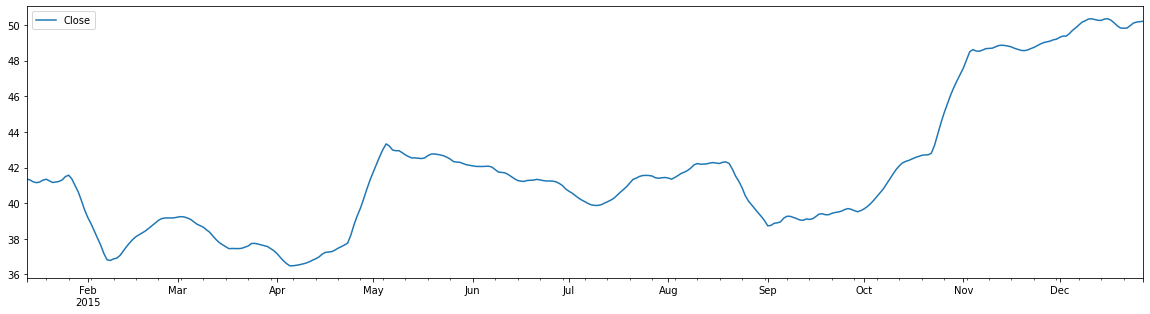

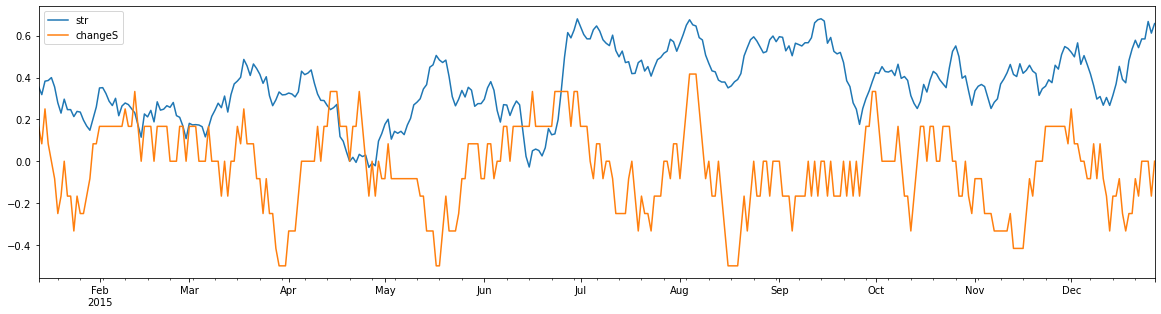

In [17]:
fromD=mini+ timedelta(days=12)
to=mini+ timedelta(days=360)
common=pd.merge(left=data2, left_index=True, right=tslaTweets, right_index=True)
commonr=common.rolling(12).mean().dropna()
commonr[fromD:to][["Close"]].plot(xlim=(fromD,to))
commonr[fromD:to][["change","diff"]].plot(xlim=(fromD,to))
commonr[fromD:to][["str","changeS"]].plot(xlim=(fromD,to))
commonr[fromD:to][['good', 'bad', 'diff', 'str', 'change']].plot(xlim=(fromD,to))

In [155]:
def createTimeSeriesData(data,shifts=5,backfill=True):
    temp=data
    for i in range(1,shifts):
        temp=pd.merge(left=data.shift(i), left_index=True, right=temp ,right_index=True)
    if backfill: return temp.fillna(method='backfill',axis=1)
    return temp

In [157]:
createTimeSeriesData(common[["Close","Open"]],shifts=5,backfill=True)

Close        Open     Close_x      Open_x     Close_y  \
2015-01-01   41.185079   41.185079   41.185079   41.185079   41.185079   
2015-01-02   41.185079   41.185079   41.185079   41.185079   41.185079   
2015-01-03   41.185079   41.185079   41.185079   41.185079   41.185079   
2015-01-04   41.185079   41.185079   41.185079   41.263698   41.443684   
2015-01-05   41.185079   41.263698   41.443684   41.355054   41.556163   
...                ...         ...         ...         ...         ...   
2019-12-27  155.402023  156.102958  155.372406  155.471121  155.944509   
2019-12-28  155.372406  155.471121  155.944509  155.030593  156.645950   
2019-12-29  155.944509  155.030593  156.645950  155.550109  156.932251   
2019-12-30  156.645950  155.550109  156.932251  157.415991  156.692511   
2019-12-31  156.932251  157.415991  156.692511  158.491111  156.019388   

                Open_y     Close_x      Open_x     Close_y      Open_y  
2015-01-01   41.185079   41.185079   41.185079   41.185079   41.263698  
2015-01-02   41.185079   41.185079   41.263698   41.443684   41.355054  
2015-01-03   41.263698   41.443684   41.355054   41.556163   41.299750  
2015-01-04   41.355054   41.556163   41.299750   41.491386   41.136548  
2015-01-05   41.299750   41.491386   41.136548   41.062580   41.098030  
...                ...         ...         ...         ...         ...  
2019-12-27  155.030593  156.645950  155.550109  156.932251  157.415991  
2019-12-28  155.550109  156.932251  157.415991  156.692511  158.491111  
2019-12-29  157.415991  156.692511  158.491111  156.019388  158.392769  
2019-12-30  158.491111  156.019388  158.392769  155.579727  156.961877  
2019-12-31  158.392769  155.579727  156.961877  155.688324  154.770195  

[1826 rows x 10 columns]

In [16]:
# from datetime import time
# table=mydb["Unprocessed"]
# up=0
# tot=0
# for entry in table.find():
    
#     tot+=1
#     if type(entry['dateCreated'])==type("asd"):
#         entry['dateCreated']=datetime.strptime(str(entry['dateCreated']),'%Y-%m-%d %H:%M:%S')
#         table.replace_one({'_id': entry["_id"]}, entry, upsert=True)
#         up+=1
# print(tot,up)
# findMissingValues(common)

In [91]:
# brokenSequencesX,yry=(sequenceBreak(slices[["Close","diff"]],5,1))
brokenSequencesX,yry=(sequenceBreak(commonr[["Close","diff"]].values,5,1))
brokenSequencesX,yry=np.array(brokenSequencesX),np.array(yry)
print(brokenSequencesX.shape,yry.shape)

trainX,valX,testX,trainY,valY,testY=makeTrainValidationTestSplit(brokenSequencesX,yry,reshapeY=(yry.shape[0],yry.shape[2]),reshapeX=(brokenSequencesX.shape[0],brokenSequencesX.shape[1],brokenSequencesX.shape[2]))
dataSets=[trainY,valY,testY]
# trainY,valY,testY=[pd.DataFrame(x.reshape(x.shape[0],x.shape[1]*x.shape[2]))[0] for x in dataset]
# trainX,valX,testX
trainY,valY,testY=[pd.DataFrame(dataSet).drop(columns=1) for dataSet in dataSets]

(1810, 5, 2) (1810, 1, 2)


In [129]:
brokenSequencesX,yry=(sequenceBreak(common["Close"],5,1))
# brokenSequencesX,yry=(sequenceBreak(common["diff"].values,5,1))
brokenSequencesX,yry=np.array(brokenSequencesX),np.array(yry)
print(brokenSequencesX.shape,yry.shape)
trainX,valX,testX,trainY,valY,testY=makeTrainValidationTestSplit(brokenSequencesX,yry,reshapeX=(brokenSequencesX.shape[0],1,brokenSequencesX.shape[1]))
dataSets=[trainY,valY,testY]
# trainY,valY,testY=[pd.DataFrame(x.reshape(x.shape[0],x.shape[1]*x.shape[2]))[0] for x in dataset]
# trainX,valX,testX
trainY,valY,testY=[pd.DataFrame(dataSet) for dataSet in dataSets]

(1821, 5) (1821, 1)


In [92]:
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=100)]
def BILSTM_model(inputShape, lstm=16,activation='relu',optimizer='adam',hidden=16):
    M = Sequential()
#     M.add(LSTM(5,activation=tf.keras.layers.LeakyReLU(),return_sequences=False ,input_shape=trainX.shape[1:]))
    M.add(Bidirectional(LSTM(5,activation="relu",return_sequences=False ,input_shape=trainX.shape[1:])))
#     M.add(Bidirectional(LSTM(lstm,input_shape=inputShape)))
#     M.add(Bidirectional(LSTM(5,return_sequences=False ,input_shape=trainX.shape[1:])))
#     M.add(tf.keras.layers.LeakyReLU())
    M.add(Dense(hidden, activation=activation))
    M.add(Dense(1))    
    M.compile(optimizer='adam',loss='mae')  
    return M
model=BILSTM_model(inputShape=(5,2), lstm=16,activation='relu',optimizer='adam',hidden=16)
history = model.fit(trainX, trainY, epochs=2000, shuffle=False, batch_size=75, validation_split=0.1, callbacks=callbacks)
predictions=model.predict(testX)

Epoch 1/2000
14/14 [==============================] - 2s 37ms/step - loss: 28.5407 - val_loss: 35.3626
Epoch 2/2000
14/14 [==============================] - 0s 17ms/step - loss: 18.3485 - val_loss: 13.0834
Epoch 3/2000
14/14 [==============================] - 0s 16ms/step - loss: 4.2158 - val_loss: 3.0617
Epoch 4/2000
14/14 [==============================] - 0s 15ms/step - loss: 2.0871 - val_loss: 1.8605
Epoch 5/2000
14/14 [==============================] - 0s 17ms/step - loss: 3.2448 - val_loss: 6.3475
Epoch 6/2000
14/14 [==============================] - 0s 18ms/step - loss: 1.6365 - val_loss: 1.6921
Epoch 7/2000
14/14 [==============================] - 0s 16ms/step - loss: 1.1556 - val_loss: 1.6477
Epoch 8/2000
14/14 [==============================] - 0s 16ms/step - loss: 1.3532 - val_loss: 2.6285
Epoch 9/2000
14/14 [==============================] - 0s 17ms/step - loss: 1.1306 - val_loss: 1.9349
Epoch 10/2000
14/14 [==============================] - 0s 17ms/step - loss: 1.0347 - va

Epoch 156/2000
14/14 [==============================] - 0s 16ms/step - loss: 0.6513 - val_loss: 0.7156
Epoch 157/2000
14/14 [==============================] - 0s 16ms/step - loss: 0.7159 - val_loss: 0.5460
Epoch 158/2000
14/14 [==============================] - 0s 17ms/step - loss: 0.9118 - val_loss: 1.0959
Epoch 159/2000
14/14 [==============================] - 0s 16ms/step - loss: 1.2887 - val_loss: 0.6074
Epoch 160/2000
14/14 [==============================] - 0s 16ms/step - loss: 1.3859 - val_loss: 0.5556
Epoch 161/2000
14/14 [==============================] - 0s 16ms/step - loss: 1.4787 - val_loss: 1.6780
Epoch 162/2000
14/14 [==============================] - 0s 16ms/step - loss: 0.5944 - val_loss: 0.5572
Epoch 163/2000
14/14 [==============================] - 0s 17ms/step - loss: 0.7722 - val_loss: 0.7256
Epoch 164/2000
14/14 [==============================] - 0s 16ms/step - loss: 0.7552 - val_loss: 0.8135
Epoch 165/2000
14/14 [==============================] - 0s 16ms/step - lo

MSE : 23.923843039807338 
RMSE: 4.8912005724369285 
NMSE: inf 
DS  : 0.994475138121547 
WDS : inf 
Ns  : 362


<ipython-input-44-f6345e54364e>:84: RuntimeWarning: divide by zero encountered in double_scalars
  "\nNMSE:",mean_squared_error(y, p,squared=False)/(max(y)-min(y)),#Normalise Mean Square Error(/max-min)
<ipython-input-44-f6345e54364e>:86: RuntimeWarning: divide by zero encountered in double_scalars
  "\nWDS :",MeanDirectionAccuracy/(max(y)-min(y)),#Weighted Directional Symmetry


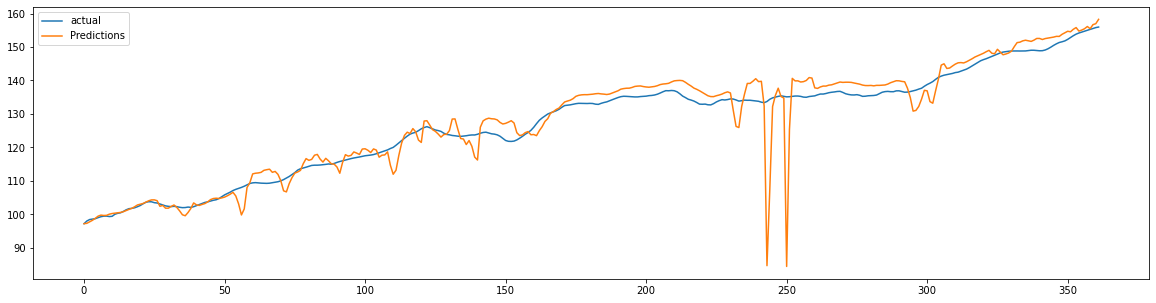

In [93]:
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
printResults( pd.DataFrame(testY), pd.DataFrame(predictions),True)

# Applying Sentiment to our models 

# Results